In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
    shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
    Args:
       file_name: Route of file containing the modified Jester dataset.
       context_dim: Context dimension (i.e. vector with some ratings from a user).
       num_actions: Number of actions (number of joke ratings to predict).
       num_contexts: Number of contexts to sample.
       shuffle_rows: If True, rows from original dataset are shuffled.
       shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
       dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
       opt_vals: Vector of deterministic optimal (reward, action) for each context.
"""
    np.random.seed(0)
    with tf.gfile.Open(file_name, 'rb') as f:
        dataset = np.load(f)
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows:
        np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    return dataset, opt_rewards, opt_actions 

/Users/xinyili/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/xinyili/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/xinyili/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/xinyili/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

In [3]:
file_name = 'jester_data_40jokes_19181users.npy'
dataset, opt_rewards, opt_actions = sample_jester_data(file_name)

In [4]:
def hw(alpha = 0.2):
    n = 18000
    k = 32
    n_a = 8

    D = dataset[:, :32]
    rewards = dataset[:, 32:]

    choices = np.zeros(n)
    theta_hat = np.zeros( (n_a,k) )
    b = np.zeros_like(theta_hat)
    A = np.zeros((n_a, k, k))
    for a in range(0, n_a):
        A[a] = np.identity(k)

    p = np.zeros(n_a)


    for i in range(n):
        x_i = D[i]
        for a in range(n_a):
            A_inv = np.linalg.inv(A[a])
            theta_hat[a] = A_inv.dot(b[a])
            ta = x_i.dot(A_inv).dot(x_i)
            a_upper_ci = alpha*np.sqrt(ta)
            a_mean = theta_hat[a].dot(x_i)
            p[a] = a_mean + a_upper_ci

        p = p + (np.random.random(len(p)) * 0.000001 )
        choices[i] = p.argmax()

        A[int(choices[i])] += np.outer(x_i, x_i)
        b[int(choices[i])] += rewards[i][int(choices[i])] * x_i 
        
    regret = []
    for i in range(18000, 19181):
        x_i = D[i]
        for a in range(n_a):
            A_inv = np.linalg.inv(A[a])
            #theta_hat[a] = A_inv.dot(b[a])
            ta = x_i.dot(A_inv).dot(x_i)
            a_upper_ci = alpha*np.sqrt(ta)
            a_mean = theta_hat[a].dot(x_i)
            p[a] = a_mean + a_upper_ci

        p = p + (np.random.random(len(p)) * 0.000001 )
        regret.append(opt_rewards[i] - rewards[i][int(p.argmax())] )
    
    return np.sum(regret)


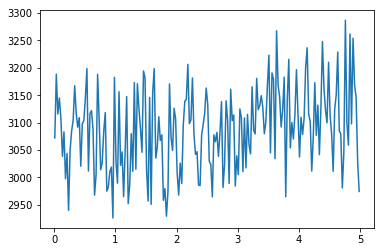

In [34]:
res= []
for alpha in np.arange(0.01, 5, 0.025):
    res.append(hw(alpha))
plt.plot(np.arange(0.01, 5, 0.025), res)
plt.show()

In [6]:
n = 18000
k = 32
n_a = 8
alpha = np.arange(0.01, 5, 0.025)[np.argmin(res)] # 0.96

D = dataset[:, :32]
rewards = dataset[:, 32:]

choices = np.zeros(n)
theta_hat = np.zeros( (n_a,k) )
b = np.zeros_like(theta_hat)
A = np.zeros((n_a, k, k))
for a in range(0, n_a):
    A[a] = np.identity(k)

p = np.zeros(n_a)


for i in range(n):
    x_i = D[i]
    for a in range(n_a):
        A_inv = np.linalg.inv(A[a])
        theta_hat[a] = A_inv.dot(b[a])
        ta = x_i.dot(A_inv).dot(x_i)
        a_upper_ci = alpha*np.sqrt(ta)
        a_mean = theta_hat[a].dot(x_i)
        p[a] = a_mean + a_upper_ci

    p = p + (np.random.random(len(p)) * 0.000001 )
    choices[i] = p.argmax()

    A[int(choices[i])] += np.outer(x_i, x_i)
    b[int(choices[i])] += rewards[i][int(choices[i])] * x_i 

regret = []
for i in range(18000, 19181):
    x_i = D[i]
    for a in range(n_a):
        A_inv = np.linalg.inv(A[a])
        #theta_hat[a] = A_inv.dot(b[a])
        ta = x_i.dot(A_inv).dot(x_i)
        a_upper_ci = alpha*np.sqrt(ta)
        a_mean = theta_hat[a].dot(x_i)
        p[a] = a_mean + a_upper_ci

    p = p + (np.random.random(len(p)) * 0.000001 )
    regret.append(opt_rewards[i] - rewards[i][int(p.argmax())] )


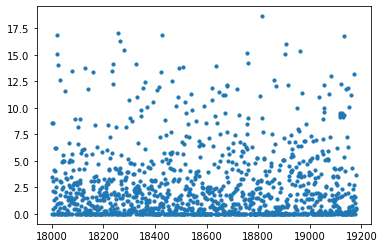

In [7]:
plt.scatter(np.arange(18000, 19181), regret, s=10)
plt.show()

In [14]:
cumulative_regret = [] 
j=0
for i in range(0,len(regret)):
    j = j+ regret[i]
    cumulative_regret.append(j) 
     


In [23]:
x_axis = list(range(1, len(cumulative_regret)+1))

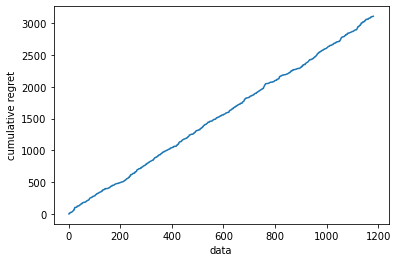

In [24]:
import matplotlib.pyplot as plt
plt.plot(x_axis, cumulative_regret)
plt.xlabel('data')
plt.ylabel('cumulative regret')
plt.show()